# DistilBERT classifier for argument relations

This DistilBERT implementation follows [Raschka et al. (2022)](https://github.com/rasbt/machine-learning-book)
from pp. 575-586. Here is the corresponding: [code](https://github.com/rasbt/machine-learning-book/blob/main/ch16/ch16-part3-bert.ipynb).

Sebastian Raschka,  Yuxi Liu and Vahid Mirjalili.  2022. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing.

## Settings and imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
import sys
PATH = r"/content/gdrive/My Drive/Colab Notebooks/AM_BERT_classification"
os.chdir(PATH)

# Create directory, if it does not exist
os.makedirs("models", exist_ok=True)

# Add the subdirectory to the sys.path
subdirectory_path = os.path.join(os.getcwd(), "scripts")
sys.path.insert(0, subdirectory_path)

Mounted at /content/gdrive


In [ ]:
from corpus_loader import CorpusLoader
from microtext_preprocessor import MicrotextRelationPrepper

import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

Specifying general settings to make the results reproducible.

In [ ]:
torch.backends.cudnn.deterministic = True
random_seed = 80
torch.manual_seed(random_seed)

available_gpu = torch.cuda.is_available()

if available_gpu:
  print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
  print("GPU not available.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU not available.


## Data

**Microtext Part One** Loading argument relations from Part One of the [Argumentative Microtext Corpus](https://peldszus.github.io/files/eca2015-preprint.pdf) with custom classes (CorpusLoader, MicrotextRelationPrepper). The relations are labeled with the following categories:`seg`, `sup`, `exa`, `reb`, `und`, `add`. In the preprocessing script, depending on the parameters (direction, window clipping), `None` relations are also added.

**Terminology**

seg - segment \
sup - support \
exa - example \
reb - rebuttal \
und - undercut \
add - addition  # *also called "linked"*

**Reference**

Andreas Peldszus and Manfred Stede. An annotated corpus of argumentative
microtexts. In D. Mohammed, and M. Lewinski, editors, Argumentation and
Reasoned Action - Proc. of the 1st European Conference on Argumentation,
Lisbon, 2015. College Publications, London, 2016

The **corpus statistics** as of 24.07.2024 is as follows (calculated with `scripts/microtext_preprocessor.py`):

| Relation statistics                | Count |
|------------------------------------|-------|
| Support relations                  | 263   |
| Example relations                  | 9     |
| Rebuttal relations                 | 108   |
| Undercutter relations              | 63    |
| Linked (add) relation              | 21    |

A few variables for both corpora, designating whether the data should include only pairs of labeled relations where the order indicates the direction of the relation as well as whether window clipping should be applied, filtering potential relations between ADUs that are not within the clipping windows distance. Without a window, all possible ordered pairs for relations sampled without replacement are calculated: For example, a set of 4 elements has 4!/(4-2)! = 12 relations.

In [ ]:
corpus_loader = CorpusLoader()
relations = MicrotextRelationPrepper()
directed = True  # Consider order of relation pairs
window = True  # If True only pairs within a window are considered
window_size = 3  # Size of window to the left and right

# The URL for the Microtext Part One as zip file
url_microtext = "https://github.com/peldszus/arg-microtexts/archive/refs/heads/master.zip"
microtext_save_path = "data/corpus_2/"
microtext_path = "data/corpus_2/arg-microtexts-master/corpus/en/"
microtext_file_type_ann = ".xml"
microtext_file_type_text = ".txt"

Loading the data:

In [ ]:
corpus_loader.download_file_from(url_microtext, microtext_save_path)

all_annotation = corpus_loader.load_files_from(microtext_path,
                                               microtext_file_type_ann)


all_set_part1 = relations.pair_extraction(all_annotation,
                                    directed,
                                    window,
                                    window_size)

print(all_set_part1.head())
print(all_set_part1.tail())

Path data/corpus_2/ already exists. Skipping download.
  label                                              pairs
0  None  (Yes, it's annoying and cumbersome to separate...
1  None  (Yes, it's annoying and cumbersome to separate...
2  None  (Yes, it's annoying and cumbersome to separate...
3   sup  (Three different bin bags stink away in the ki...
4  None  (Three different bin bags stink away in the ki...
     label                                              pairs
2191  None  (Increasing penalties is therefore the right w...
2192  None  (A dog dirt-free city will be more attractive ...
2193  None  (A dog dirt-free city will be more attractive ...
2194   sup  (A dog dirt-free city will be more attractive ...
2195   und                                           [a4, c3]


**Microtext Part Two** Loading argument relations from Part Two of the [Argumentative Microtext Corpus](https://aclanthology.org/W18-5218.pdf) with custom classes (CorpusLoader, MicrotextRelationPrepper). The relations are labeled with the following categories:`seg`, `sup`, `exa`, `reb`, `und`, `add`. In the preprocessing script, depending on the parameters (direcction, window clipping), `None` relations are also added.

**Reference**

Maria Skeppstedt, Andreas Peldszus and Manfred Stede. More or less
controlled elicitation of argumentative text: Enlarging a microtext corpus via
crowdsourcing. In Proc. 5th Workshop in Argumentation Mining (at EMNLP),
Brussels, 2018

The **corpus statistics** as of 24.07.2024 is as follows:

| Relation statistics                | Count |
|------------------------------------|-------|
| Support relations                  | 467   |
| Example relations                  | 23    |
| Rebuttal relations                 | 137   |
| Undercutter relations              | 77    |
| Linked (add) relation              | 57    |

In [ ]:
# The URL for Part Two of the Microtext Part Two as zip file
url_microtext = "https://github.com/discourse-lab/arg-microtexts-part2/archive/refs/heads/master.zip"
microtext_save_path = "data/corpus_3/"
microtext_path = "data/corpus_3/arg-microtexts-part2-master/corpus/"
microtext_file_type_ann = ".xml"
microtext_file_type_text = ".txt"

corpus_loader.download_file_from(url_microtext, microtext_save_path)

all_annotation = corpus_loader.load_files_from(microtext_path,
                                               microtext_file_type_ann)


all_set_part2 = relations.pair_extraction(all_annotation,
                                    directed,
                                    window,
                                    window_size)

print(all_set_part2.head())
print(all_set_part2.tail())

Path data/corpus_3/ already exists. Skipping download.
  label                                              pairs
0  None  (Hunting is good for the environment, because ...
1  None  (Hunting is good for the environment, Getting ...
2  None  (Hunting is good for the environment, It also ...
3   sup  (because overpopulated species can be thinned ...
4  None  (because overpopulated species can be thinned ...
     label                                              pairs
3673  None  (However, this could also cause disturbances a...
3674  None  (Smaller families have the potential to be tig...
3675  None  (Smaller families have the potential to be tig...
3676  None  (Smaller families have the potential to be tig...
3677   und                                           [a4, c2]


Let us merge the two parts of the extended corpus.

In [ ]:
all_set = pd.concat([all_set_part1, all_set_part2], ignore_index=True)
print(all_set.iloc[4])
print(all_set.head())
print(all_set.tail())

# "add" and "und" instances
print("'add' and 'und' instances:")
print(len(all_set[all_set["label"] == "add"]))
print(len(all_set[all_set["label"] == "und"]))

label                                                 None
pairs    (Three different bin bags stink away in the ki...
Name: 4, dtype: object
  label                                              pairs
0  None  (Yes, it's annoying and cumbersome to separate...
1  None  (Yes, it's annoying and cumbersome to separate...
2  None  (Yes, it's annoying and cumbersome to separate...
3   sup  (Three different bin bags stink away in the ki...
4  None  (Three different bin bags stink away in the ki...
     label                                              pairs
5869  None  (However, this could also cause disturbances a...
5870  None  (Smaller families have the potential to be tig...
5871  None  (Smaller families have the potential to be tig...
5872  None  (Smaller families have the potential to be tig...
5873   und                                           [a4, c2]
'add' and 'und' instances:
78
140


However, in the following training and testing, the undercut and addition relation are left out because additions and undercutters do not relate two ADUs, but an ADU with another relation, which is beyond the scope of this experiment.

In [ ]:
# Remove instances with the label "add" and "und"
all_set = all_set[all_set["label"] != "add"]
all_set = all_set[all_set["label"] != "und"]

print(len(all_set))

5656


Applying numeric labels to training and test set. In the undirected case, we want to test whether a relation between two ADUs holds, regardless of its type and direction, making this a binary classification task. In the directed scenario we want a multi-class classification task with direction.

**Undirected?**:
>ADU1 -rel- ADU2

**Directed?**:
>ADU1 -sup-> ADU2\
ADU1 -exa-> ADU2\
ADU1 -reb-> ADU2\
ADU1 -None-> ADU2

In [ ]:
def replace_labels(label):
    if label != "None":
        return "rel"
    else:
        return label

In [ ]:
if not directed:
    all_set["label"]  = all_set["label"] .apply(replace_labels)

    label_mapping = {
    "None": 0,
    "rel": 1,
    }
else:
    label_mapping = {
        "sup": 0,
        "exa": 1,
        "reb": 2,
        "None": 3,
    }

all_set["label"] = all_set["label"].map(label_mapping)
print(all_set.head())

   label                                              pairs
0      3  (Yes, it's annoying and cumbersome to separate...
1      3  (Yes, it's annoying and cumbersome to separate...
2      3  (Yes, it's annoying and cumbersome to separate...
3      0  (Three different bin bags stink away in the ki...
4      3  (Three different bin bags stink away in the ki...


Splitting the training set into **training**, **validation**, and **test** sets: We aim for a 70:10:20 split.

In [ ]:
X = all_set["pairs"]
y = all_set["label"]


X_train, X_split, y_train, y_split = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=random_seed,
                                                      stratify=y)

# To arrive at a validation set that consists of 10% of overall datapoints
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split,
                                                    test_size=0.6666,
                                                    random_state=random_seed,
                                                    stratify=y_split)

X_train = pd.DataFrame(X_train)
X_valid = pd.DataFrame(X_valid)
X_test = pd.DataFrame(X_test)

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(3959, 1)
(565, 1)
(1132, 1)


In the Microtext corpus the amount of relations that have a label, compared to the None class is large enough so that we can continue without down-sampling the majority class.

In [ ]:
print("Amount of relation labels that are not None")
class_label = y_train[y_train != 3].shape[0]
print(class_label)

print("Amount of relation labels that are None")
class_none_label = y_train[y_train == 3].shape[0]
print(class_none_label)

print("Share of labels with respect to None:")
print(class_label / (class_label + class_none_label))

Amount of relation labels that are not None
584
Amount of relation labels that are None
3375
Share of labels with respect to None:
0.1475119979792877


## Data preparation

As the data for the ADU pairs is still stored as tuples, we need to split them in half so that the tokenizer can create a schema that resembles the following structure

> [CLS] Proposition 1 [SEP] Proposition 2 [Sep] [PAD] [PAD] ...

Where [CLS] and [SEP] are special tokens used for telling the BERT model where propositions start and end. [PAD] is used for padding so that each sample is of equal size.

In [ ]:
# Separate dataframes with tuples into two separate frames
X_train_prop_a = X_train.applymap(lambda x: x[0])
X_train_prop_b = X_train.applymap(lambda x: x[1])
X_valid_prop_a = X_valid.applymap(lambda x: x[0])
X_valid_prop_b = X_valid.applymap(lambda x: x[1])
X_test_prop_a = X_test.applymap(lambda x: x[0])
X_test_prop_b = X_test.applymap(lambda x: x[1])

# Accessing values from the frames
X_train_prop_a = X_train_prop_a.values.flatten().tolist()
X_train_prop_b = X_train_prop_b.values.flatten().tolist()
X_valid_prop_a = X_valid_prop_a.values.flatten().tolist()
X_valid_prop_b = X_valid_prop_b.values.flatten().tolist()
X_test_prop_a = X_test_prop_a.values.flatten().tolist()
X_test_prop_b = X_test_prop_b.values.flatten().tolist()

print(X_train_prop_a[0:3])
print(X_train_prop_b[0:3])

["However, people can't always distinguish between the two.", 'However these are clearly stated on the package insert,', 'which is why students also ought to be involved in this cost factor.']
["When you spend your time watching unrealistic romantic movies, you start thinking it's reality.", 'The morning-after pill has a number of side effects.', 'But education must not be a question of money in a wealthy society such as Germany.']


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
    )

train_encodings = tokenizer(X_train_prop_a,
                            X_train_prop_b,
                            truncation=True,
                            padding=True)
valid_encodings = tokenizer(list(X_valid_prop_a),
                            list(X_valid_prop_b),
                            truncation=True,
                            padding=True)
test_encodings = tokenizer(list(X_test_prop_a),
                           list(X_test_prop_b),
                           truncation=True,
                           padding=True)

print(len(train_encodings["input_ids"]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

3959


Let's visualize the tokenized instances with corresponding ids and masks.

In [ ]:
for i in range(3):
    print(f"input_ids: {train_encodings['input_ids'][i]}")
    print(f"attention_mask: {train_encodings['attention_mask'][i]}")
    print(f"sentence: {tokenizer.decode(train_encodings['input_ids'][i])}")

input_ids: [101, 2174, 1010, 2111, 2064, 1005, 1056, 2467, 10782, 2090, 1996, 2048, 1012, 102, 2043, 2017, 5247, 2115, 2051, 3666, 4895, 22852, 6553, 6298, 5691, 1010, 2017, 2707, 3241, 2009, 1005, 1055, 4507, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sentence: [CLS] however, people can't always distinguish between the two. [SEP] when you spend your time watching unrealistic romantic movies, you start thinking it's reality. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

A self-defined data class helps with customizing all related features and functions.

In [ ]:
class CDCPDataset(torch.utils.data.Dataset):
    """
    Self-defined data class to customize features by changing some magic
    methods. __getitem__ only extraxts the most relevant information from the
    encodings.

    Cf. Raschka et al. (2022, p. 577-8)
    """

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        item["label"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Creating torch Dataloaders

The data was already shuffled with the splits to stratisfy the classes for the test and validation sets. This was also necessary because Scikit learn's resample method works with shuffling.

Shuffling the data stabilizes the training process and can potentially enhance the model's final performance.

In [ ]:
train_dataset = CDCPDataset(train_encodings, y_train)
valid_dataset = CDCPDataset(valid_encodings, y_valid)
test_dataset = CDCPDataset(test_encodings, y_test)

batch_size = 128  # Slight boost for T4 GPU if batch size is 128

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=True
)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))


3959
565
1132


## Fine-tuning the model

### [DistilBERT model](https://huggingface.co/distilbert/distilbert-base-uncased):

The DistilBERT base uncased model is used as it is faster, lighter, and smaller than BERT [(Sanh et al. 2019)](https://arxiv.org/abs/1910.01108), but reaches performance results close to BERT. ***DistilBertForSequenceClassification*** is designed for sequence classification tasks. It includes a classification head on top of the pooled output, specifically for tasks like sentiment analysis, spam detection, etc. When we instantiate the model, the loss function used is `CrossEntropyLoss`. Passing the labels along with the input to the model is sufficient, the Hugging Face library automatically computes the loss if the labels are provided.

In [ ]:
if not directed:
    labels_n = 2
else:
    labels_n = 4

# Labels either: Relation or None, Or: Support, example, rebuttal, None
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=labels_n
)
model_name = f"models/DistilBert_relation_micro_class_dir_window3_1_3.pt"
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = LinearLR(optimizer,
                     start_factor=1.0,
                     end_factor=0.3,
                     total_iters=10)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy function to evaluate the model:

In [ ]:
def compute_accuracy(model, data_loader, device):
    """
    Cf. Raschka et al. (2022, p. 579)
    """
    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            predicted_labels = torch.argmax(logits, dim=1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

        return correct_pred.float()/num_examples * 100

F1 function to evaluate the model:

In [ ]:
def compute_f1_scores(model, data_loader, device):
    with torch.no_grad():

        all_labels = []
        all_predictions = []

        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            predicted_labels = torch.argmax(logits, dim=1)

            # If the tensors are on the GPU, .cpu() moves them to the CPU.
            # This step is necessary because the numpy() method is not supported
            # on GPU tensors.
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

        # Create a report dictionary
        report = classification_report(all_labels,
                                       all_predictions,
                                       output_dict=True)


        return report

Function to evaluate loss:

In [ ]:
def compute_loss(model, data_loader, device):
    # Dropout is disabled and batch normalization uses the learned statistics
    # instead of the statistics of the current batch.
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss, logits = outputs["loss"], outputs["logits"]

            running_loss += loss.item()

    final_loss = running_loss/ len(data_loader)

    return final_loss

### Training:

In [ ]:
start_time = time.time()
num_epochs = 5

train_acc_history = [0] * num_epochs
valid_acc_history = [0] * num_epochs

train_loss_history = [0] * num_epochs
valid_loss_history = [0] * num_epochs

# Cf. Raschka et al. (2022, p. 580-1)
for epoch in range(num_epochs):

    model.train()
    running_train_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):

        # Prepare data
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss, logits = outputs["loss"], outputs["logits"]

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Scheduler step (with warmup?)
        scheduler.step()

        # Logging
        if not batch_idx % 10:
            print(f"Epoch: {epoch+1:04d}/{num_epochs:04d}"
                  f" | Batch "
                  f"{batch_idx:04d}/"
                  f"{len(train_loader):04d} | "
                  f"Loss: {loss:.4f}")

    train_loss = running_train_loss / len(train_loader)
    valid_loss = compute_loss(model, valid_loader, device)

    train_loss_history[epoch] = train_loss
    valid_loss_history[epoch] = valid_loss

    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Training Loss: {train_loss:.4f} | "
          f"Validation Loss: {valid_loss:.4f}")

    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device)
        valid_acc = compute_accuracy(model, valid_loader, device)
        print(f"Training accuracy: "
              f"{train_acc:.2f}%"
              f"\nValidation accuracy: "
              f"{valid_acc:.2f}%"
              )

    train_acc_history[epoch] = train_acc
    valid_acc_history[epoch] = valid_acc

# Evaluate and save model
model.eval()
torch.save(model.state_dict(), model_name)

print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")

Epoch: 0001/0005 | Batch 0000/0031 | Loss: 1.3714
Epoch: 0001/0005 | Batch 0010/0031 | Loss: 0.6006
Epoch: 0001/0005 | Batch 0020/0031 | Loss: 0.5403
Epoch: 0001/0005 | Batch 0030/0031 | Loss: 0.4693
Epoch: 1/5 | Training Loss: 0.6637 | Validation Loss: 0.5289
Training accuracy: 85.25%
Validation accuracy: 85.31%
Epoch: 0002/0005 | Batch 0000/0031 | Loss: 0.4439
Epoch: 0002/0005 | Batch 0010/0031 | Loss: 0.5607
Epoch: 0002/0005 | Batch 0020/0031 | Loss: 0.5298
Epoch: 0002/0005 | Batch 0030/0031 | Loss: 0.5314
Epoch: 2/5 | Training Loss: 0.5237 | Validation Loss: 0.4933
Training accuracy: 85.25%
Validation accuracy: 85.31%
Epoch: 0003/0005 | Batch 0000/0031 | Loss: 0.4727
Epoch: 0003/0005 | Batch 0010/0031 | Loss: 0.6436
Epoch: 0003/0005 | Batch 0020/0031 | Loss: 0.5892
Epoch: 0003/0005 | Batch 0030/0031 | Loss: 0.6090
Epoch: 3/5 | Training Loss: 0.5187 | Validation Loss: 0.4916
Training accuracy: 85.25%
Validation accuracy: 85.31%
Epoch: 0004/0005 | Batch 0000/0031 | Loss: 0.3476
Epoch

## Evaluation

Visualizing training accuracy with Matplotlib.

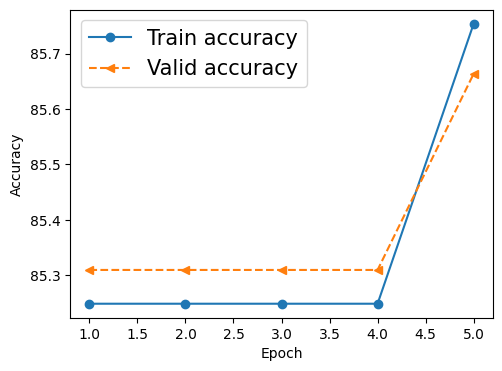

In [ ]:
x_arr = np.arange(len(train_acc_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, [e.cpu() for e in train_acc_history],
        "-o",
        label="Train accuracy")
ax.plot(x_arr, [e.cpu() for e in valid_acc_history],
        "--<",
        label="Valid accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(fontsize=15)

Visualizing loss during training with Matplotlib.


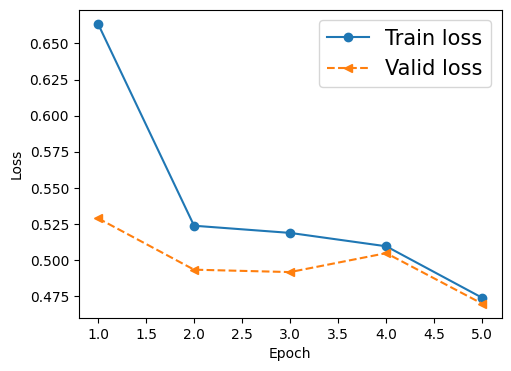

In [ ]:
x_arr = np.arange(len(train_loss_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, train_loss_history, "-o", label="Train loss")
ax.plot(x_arr, valid_loss_history, "--<", label="Valid loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(fontsize=15)

# Metrics:

To report a full range of metrics, we can use the customized `compute_f1_scores`. The function returns `precision`, `recall`, `accuracy`, `macro F1` and `weighted F1` scores. For an imbalanced distribution of classes, it is reasonable to consider the weighted F1 score because it takes the support count for each class into account.

Macro F1 := Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

Micro F1 / weighted average := Calculate metrics globally by counting the total true positives false negatives and false positives.

In [ ]:
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_name))
else:
    model.load_state_dict(torch.load(model_name,
                                     map_location=torch.device("cpu")))

report = compute_f1_scores(model, test_loader, device)
print(f"Test score: {report}")

Individual F1 score: {'0': {'precision': 0.6666666666666666, 'recall': 0.06611570247933884, 'f1-score': 0.12030075187969926, 'support': 121.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 39.0}, '3': {'precision': 0.8589285714285714, 'recall': 0.9968911917098445, 'f1-score': 0.9227817745803356, 'support': 965.0}, 'accuracy': 0.8568904593639576, 'macro avg': {'precision': 0.3813988095238095, 'recall': 0.2657517235472958, 'f1-score': 0.26077063161500874, 'support': 1132.0}, 'weighted avg': {'precision': 0.8034741502608109, 'recall': 0.8568904593639576, 'f1-score': 0.7995060101126037, 'support': 1132.0}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finally, we can log the results at `results/log.json`.

In [ ]:
file_path = "results/log.json"

try:
    with open(file_path, "r") as file:
        data = json.load(file)
except FileNotFoundError:
    data = {}
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

data[model_name] = report

with open(file_path, "w") as file:
    json.dump(data, file, indent=4)

print(f"Updated data written to {file_path}.")

Updated data written to results/log.json.
